In [6]:
import seaborn as sns
import csv
import pandas as pd
import os
import openpyxl
import matplotlib.pyplot as plt
import datetime

In [17]:
#distance, true_distance, correct, is_in_pool, read_offset, matched_offset, true_offset
def get_offset(filepath,filename):
    filepath = '{}/{}'.format(filepath, filename)
    with open(filepath,'r') as f:

        reader = csv.reader(f)
        l = [row for row in reader]
        
        data = [[float(el) for el in row] for row in l[1:]]
        avg_dist_correct = 0
        avg_dist_wrong = 0
        avg_offset_diff = 0
        dist_correct_list = []
        dist_wrong_list = []
        true_dist_correct = []
        true_dist_wrong = []
        offset_diff_list = []
        correct_num = 0
        wrong_num = 0
        for row in data:
            dist = row[0]
            true_dist = row[1]
            correct = row[2]
            if correct:
                correct_num +=1
                diff = abs(int(row[5])-int(row[6]))
                avg_offset_diff += diff
                avg_dist_correct += dist
                dist_correct_list.append(dist)
                offset_diff_list.append(diff)
                true_dist_correct.append(true_dist)
            else:
                wrong_num +=1
                avg_dist_wrong += dist
                dist_wrong_list.append(dist)
                true_dist_wrong.append(true_dist)

        return avg_offset_diff/correct_num, avg_dist_correct/correct_num, avg_dist_wrong/wrong_num, offset_diff_list, dist_correct_list, dist_wrong_list, true_dist_correct, true_dist_wrong

<Axes: xlabel='offset_diff'>

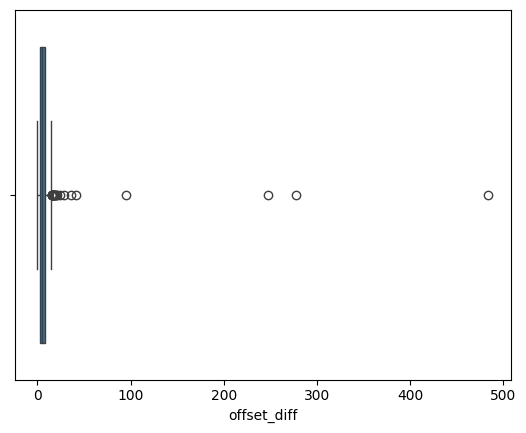

In [19]:
data = {}
data2 = {}
filepath = '/cluster/scratch/junbzhang/out'
filename = 'ts_annoy_{}.csv'.format(8)
_,_,_, offset_l, dist_corr_l, dist_wron_l, true_dist_corr, true_dist_wrong = get_offset(filepath, filename)
offset_l = [el for el in offset_l if el < 1000]
df_offset = pd.DataFrame(offset_l,columns=['offset_diff'])
data['correct'] = dist_corr_l
data['wrong'] = dist_wron_l
data2['correct'] = dist_corr_l
data2['wrong'] = dist_wron_l
data2['true correct'] = true_dist_corr
data2['true wrong'] = true_dist_wrong

sns.boxplot(data=df_offset,x='offset_diff')



<Axes: >

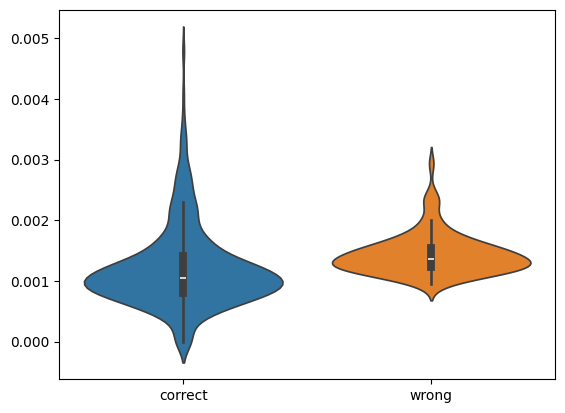

In [20]:
sns.violinplot(data=data)

<Axes: >

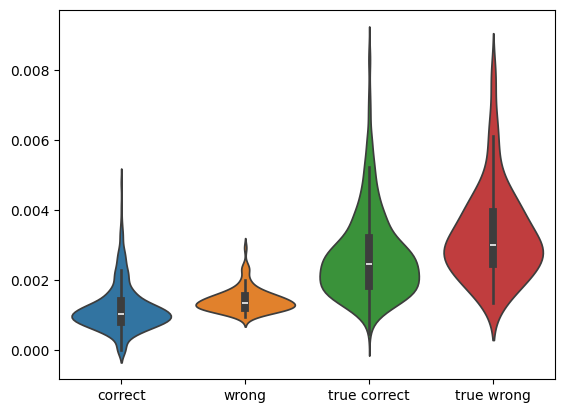

In [ ]:

sns.violinplot(data=data)

In [7]:
def get_eval(file_path, file_name) -> pd.DataFrame:
    filepath = '{}/{}'.format(file_path, file_name)
    
    with open(filepath,'r') as f:

        reader = csv.reader(f)
        l = [row for row in reader]
        windows = l[0]
        strides = l[1]
        df = pd.DataFrame(l[2:], index = windows, columns = strides)
        return df

In [10]:
subseq_len = 8
filepath = 'scratch/eval'
filename = 'annoy_{}.csv'.format(subseq_len)
df = get_eval(filepath, filename)

In [16]:
sns.lineplot()

Index(['100', '120'], dtype='object')


In [ ]:
#sketch_dim, kmer_len, window, stride, fpr, foundr, vectorizing_time build_time, query_time
def get_df(filepath, filename):
    filepath = '{}/{}'.format(filepath, filename)
    
    df = pd.read_csv(filepath,names=['sketch_dim','kmer','window','stride','fpr','missr','vectorizing_time','build_time','query_time'])
   
    return df.sort_values(by=['sketch_dim','kmer','window','stride']).reset_index(drop=True)

In [ ]:
def df_to_excel(df, file_path, excel_name, sheet_name, header ='', row = 0, col = 0):
        filepath = '{}/{}.xlsx'.format(file_path, excel_name)
        first_time = False
        
        if not os.path.isfile(filepath):
            df_empty = pd.DataFrame()
            df_empty.to_excel(filepath)
            first_time = True
            
        workbook = openpyxl.load_workbook(filepath)
        
        if first_time and not (sheet_name in workbook.sheetnames):
            ex_sheet = workbook['Sheet1']
            ex_sheet.title = sheet_name
            workbook.save(filepath)
        workbook.close()
        
        with pd.ExcelWriter(filepath, engine='openpyxl', mode='a', if_sheet_exists='overlay') as writer: 
            df.to_excel(writer, sheet_name=sheet_name, startrow = row, startcol = col)
            workbook = writer.book
            worksheet = workbook[sheet_name]
            worksheet.cell(row=row+1, column = col+1).value = header
            workbook.save(filepath)
            workbook.close()

In [ ]:
def write_to_excel(filepath, excel_name, df):
    df_group = df.groupby(['sketch_dim','kmer'])
    
    offset=0
    check_key = -1
    for key, table in df_group:
        sketch_dim = key[0]
        if check_key != sketch_dim:
            offset = 0
        kmer = key[1]
        #table['vectorizing_time'] = table['vectorizing_time'].apply(lambda num: str(datetime.timedelta(seconds=round(num,2))))
        table['build_time'] = table['build_time'].apply(lambda num: str(datetime.timedelta(seconds=round(num,2))))
        table['query_time'] = table['query_time'].apply(lambda num: str(datetime.timedelta(seconds=round(num,2))))
        df_table = table.pivot(index='window',columns='stride',values='fpr')
        #df_vec = table.pivot(index='window',columns='stride',values='vectorizing_time')
        df_build = table.pivot(index='window',columns='stride',values='build_time')
        df_query = table.pivot(index='window',columns='stride',values='query_time')
        row_num, col_num = df_table.shape
        df_to_excel(df_table, filepath, excel_name=excel_name,sheet_name=str(sketch_dim), header='t={}'.format(kmer),row=offset)  
        #df_to_excel(df_vec, filepath, excel_name=excel_name,sheet_name=str(sketch_dim), header='vec_time'.format(kmer),row=offset,col = col_num + 1) 
        df_to_excel(df_build, filepath, excel_name=excel_name,sheet_name=str(sketch_dim), header='build_time'.format(kmer),row=offset, col = 2*(col_num + 1)) 
        df_to_excel(df_query, filepath, excel_name=excel_name,sheet_name=str(sketch_dim), header='query_time'.format(kmer),row=offset, col = 3*(col_num + 1)) 
        offset+=row_num
        check_key = sketch_dim

In [ ]:
k_search = ''
index_type = 'annoy'
vectorizer = 'tensor_sketch'
filepath = 'eval'
filename = '{}_{}_{}nns.csv'.format(index_type, vectorizer,k_search)
df_all = get_df(filepath, filename)

In [ ]:
window = 40
df_selec = df_all.loc[(df_all['window'] == window)].reset_index()
print(df_selec)
sns.lineplot(data=df_selec,x='stride',y='vectorizing_time',hue='kmer',linewidth=2.0).set_title('vec_time for 256')

In [ ]:
sns.lineplot(data=df_selec,x='stride',y='build_time',hue='kmer',linewidth=2.0).set_title('build_time for 256')

In [ ]:
sns.lineplot(data=df_selec,x='stride',y='query_time',hue='kmer',linewidth=2.0).set_title('query_time for 256')